<a href="https://colab.research.google.com/github/ljn1999/APS360-Applied-Fundamentals-of-Machine-Learning/blob/master/Lab5/Lab_5_Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Spam Detection

**Deadline**: Thursday, March 12, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Karthik Bhaskar 

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1WLH-Ihyb_2fQ8vLXLC1w9jNX5m5Lyl3C#scrollTo=rWiUqJJTa9z6

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [ ]:
print_ham = True
for line in open('SMSSpamCollection'):
    if line.split()[0] == "ham" and print_ham:
      print("Non-spam example: ", line)
      print("Non-spam label is: ", line.split()[0])
      print_ham = False
    elif line.split()[0] == "spam":
      print("Spam example: ", line)
      print("Spam label is: ", line.split()[0])
      break

Non-spam example:  ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Non-spam label is:  ham
Spam example:  spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

Spam label is:  spam


### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
count_spam = 0
count_ham = 0
for line in open('SMSSpamCollection'):
    if line.split()[0] == "spam":
      count_spam = count_spam+1
    else:
      count_ham = count_ham+1

print("count for spam messages:", count_spam)
print("count for non-spam messages:", count_ham)

count for spam messages: 747
count for non-spam messages: 4827


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

In [ ]:
# advantage: the vocabulary is much smaller, require less memory, and have faster inference. 
#            Can take mis-spelling into consideration.
# disadvantage: more tokens for one data sample, requires bigger hidden layer, thus more complex
#               need to learn spelling in addition to syntax, semantics.
#               The accuracy is probably lower than word-based problem.

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [ ]:
import torchtext

text_field = torchtext.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.data.TabularDataset("SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)

print(dataset[0].sms)
print(dataset[0].label)
train, valid, test = dataset.split([0.6, 0.2, 0.2], True) # reshuffle = True
print(len(train))
print(len(valid))
print(len(test))

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
0
3343
1115
1114


### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating non-spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [ ]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

# the reason is that: to make the probability of a spam and a ham appears to be 
# the same. If we don't duplicate the spam examples, and if our model classify
# all emails to be non-spam, we would get an accuracy of 0.866, while the model
# is actually very bad.
print(len(train.examples))

6031


### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [ ]:
text_field.build_vocab(train)
print(text_field.vocab.stoi)
print(text_field.vocab.itos)
#text_field.vocab.stoi is a collections.defaultdict instance mapping token strings to numerical identifiers. That is, mapping every character to a number.
#text_field.vocab.itos is a list of token strings indexed by their numerical identifiers. That is, the list of characters in stoi with the same order.

defaultdict(<function _default_unk_index at 0x7ff10655f9d8>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, 'h': 13, 'd': 14, '0': 15, '.': 16, 'c': 17, 'm': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, '2': 25, 'b': 26, '8': 27, 'k': 28, 'T': 29, 'v': 30, '5': 31, 'E': 32, 'S': 33, 'C': 34, 'I': 35, '7': 36, 'O': 37, 'x': 38, '4': 39, 'A': 40, '6': 41, 'N': 42, '3': 43, 'R': 44, '!': 45, ',': 46, '9': 47, 'W': 48, 'P': 49, 'M': 50, 'U': 51, 'L': 52, 'H': 53, 'D': 54, '?': 55, '/': 56, "'": 57, 'G': 58, 'Y': 59, 'B': 60, 'F': 61, '£': 62, '-': 63, ':': 64, '&': 65, 'z': 66, 'X': 67, 'V': 68, 'K': 69, 'j': 70, ')': 71, 'J': 72, ';': 73, '+': 74, '*': 75, '(': 76, '"': 77, 'q': 78, 'Q': 79, '#': 80, '>': 81, '=': 82, 'Z': 83, '@': 84, 'ü': 85, '<': 86, 'Ü': 87, '\x92': 88, '$': 89, '|': 90, '‘': 91, '_': 92, '[': 93, ']': 94, '%': 95, '’': 96, '\x93': 97, 'ú': 98, '“': 99, '…': 100, '–': 101, '\x94': 102, '

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

In [ ]:
# <unk> represents unknown tokens
# <pad> represents padding, because when the GPU or CPU processes my training 
# data in batches, all sequences in my batch should have the same length, the 
# padding will be used if the sequence of character has smaller length than
# the maximum length.

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
count = 1
for batch in train_iter:
    if count>10:
      break
    else:
      print("Batch number:", count, "max length is:", int(batch.sms[1][0]))
      sum = 0
      for message in range(0, len(batch.sms[1])):
        sum = sum + batch.sms[1][0] - batch.sms[1][message]
      print("Batch number:", count, "number of <pad> is:", int(sum))
      count = count+1

# inside batch.sms, there are two elements, batch.sms[0] contains 32 after-padding
# tensors, all with the same length. Batch.sms[1] contains 32 elements in decending 
# order and each of them represents the actual length of each message. Therefore, 
# the first element in batch.sms[1] is the max length, and the sum of max length 
# - each actual length is the sum of paddings.  

Batch number: 1 max length is: 46
Batch number: 1 number of <pad> is: 24
Batch number: 2 max length is: 90
Batch number: 2 number of <pad> is: 33
Batch number: 3 max length is: 72
Batch number: 3 number of <pad> is: 48
Batch number: 4 max length is: 22
Batch number: 4 number of <pad> is: 0
Batch number: 5 max length is: 106
Batch number: 5 number of <pad> is: 37
Batch number: 6 max length is: 24
Batch number: 6 number of <pad> is: 1
Batch number: 7 max length is: 114
Batch number: 7 number of <pad> is: 36
Batch number: 8 max length is: 22
Batch number: 8 number of <pad> is: 139
Batch number: 9 max length is: 126
Batch number: 9 number of <pad> is: 24
Batch number: 10 max length is: 33
Batch number: 10 number of <pad> is: 14


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
input_size = len(text_field.vocab.itos)

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        self.name = "RNN"
        super(RNN, self).__init__()
        self.emb = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb[x]
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [ ]:
def get_accuracy(model, data, batch_size):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    data_loader = torchtext.data.BucketIterator(data,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

    correct, total = 0, 0
    for message, labels in data_loader:
        output = model(message[0])
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [ ]:
def train_rnn_network(model, train, valid, batch_size, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, valid_losses, train_acc, valid_acc = [], [], [], []
    epochs = []
    train_loader = torchtext.data.BucketIterator(train,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms), 
                                           sort_within_batch=True,        
                                           repeat=False)     
    valid_loader = torchtext.data.BucketIterator(valid,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms), 
                                           sort_within_batch=True,        
                                           repeat=False) 
    for epoch in range(num_epochs):
        for message, labels in train_loader:
            optimizer.zero_grad()
            pred = model(message[0])
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        train_losses.append(float(loss))

        for message, labels in valid_loader:
            pred = model(message[0])
            loss = criterion(pred, labels)
        valid_losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train, batch_size))
        valid_acc.append(get_accuracy(model, valid, batch_size))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
        model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

    # plotting
    plt.title("Training Curve")
    plt.plot(train_losses, label="Train")
    plt.plot(valid_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Epoch 1; Loss 0.702902; Train Acc 0.551981; Val Acc 0.234081
Epoch 2; Loss 0.692585; Train Acc 0.635881; Val Acc 0.485202
Epoch 3; Loss 0.681833; Train Acc 0.705024; Val Acc 0.786547
Epoch 4; Loss 0.659983; Train Acc 0.747637; Val Acc 0.820628
Epoch 5; Loss 0.268582; Train Acc 0.609849; Val Acc 0.872646
Epoch 6; Loss 0.416454; Train Acc 0.855082; Val Acc 0.918386
Epoch 7; Loss 0.618589; Train Acc 0.865362; Val Acc 0.926457
Epoch 8; Loss 0.298372; Train Acc 0.899519; Val Acc 0.892377
Epoch 9; Loss 0.334672; Train Acc 0.904991; Val Acc 0.950673
Epoch 10; Loss 0.324901; Train Acc 0.913116; Val Acc 0.907623
Epoch 11; Loss 0.178074; Train Acc 0.916100; Val Acc 0.930045
Epoch 12; Loss 0.293267; Train Acc 0.911623; Val Acc 0.946188
Epoch 13; Loss 0.524207; Train Acc 0.900348; Val Acc 0.877130
Epoch 14; Loss 0.117158; Train Acc 0.929697; Val Acc 0.931839
Epoch 15; Loss 0.115630; Train Acc 0.929365; Val Acc 0.956951
Epoch 16; Loss 0.179250; Train Acc 0.903333; Val Acc 0.956054
Epoch 17; Loss 0.

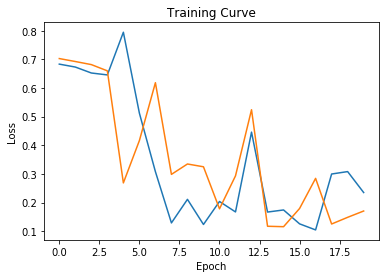

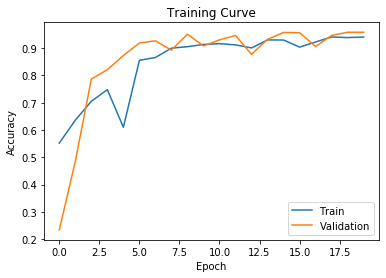

In [ ]:
# firstly use the RNN model given in tutorial, with out = self.fc(out[:, -1, :])
# I chose num of hidden units = 100, batch_size = 64, num_of_epoches = 20 and lr = 5e-5 (a very small lr) as a start
model = RNN(input_size, 100, 2)   
train_rnn_network(model, train, valid, 64, 20, 5e-5)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

Epoch 1; Loss 0.370070; Train Acc 0.716797; Val Acc 0.875336
Epoch 2; Loss 0.162075; Train Acc 0.852097; Val Acc 0.917489
Epoch 3; Loss 0.984406; Train Acc 0.519980; Val Acc 0.134529
Epoch 4; Loss 0.711957; Train Acc 0.756094; Val Acc 0.788341
Epoch 5; Loss 0.727841; Train Acc 0.798209; Val Acc 0.840359
Epoch 6; Loss 0.164832; Train Acc 0.911126; Val Acc 0.911211
Epoch 7; Loss 0.264832; Train Acc 0.661416; Val Acc 0.611659
Epoch 8; Loss 0.920964; Train Acc 0.605206; Val Acc 0.554260
Epoch 9; Loss 0.188931; Train Acc 0.903996; Val Acc 0.910314
Epoch 10; Loss 0.087165; Train Acc 0.936163; Val Acc 0.945291
Epoch 11; Loss 0.115031; Train Acc 0.934173; Val Acc 0.947982
Epoch 12; Loss 0.287420; Train Acc 0.943790; Val Acc 0.963229
Epoch 13; Loss 0.304945; Train Acc 0.901840; Val Acc 0.948879
Epoch 14; Loss 0.066525; Train Acc 0.953739; Val Acc 0.965919
Epoch 15; Loss 0.252385; Train Acc 0.948765; Val Acc 0.939910
Epoch 16; Loss 0.017014; Train Acc 0.933013; Val Acc 0.968610
Epoch 17; Loss 0.

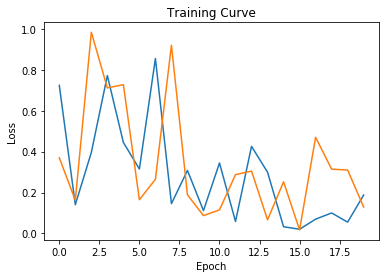

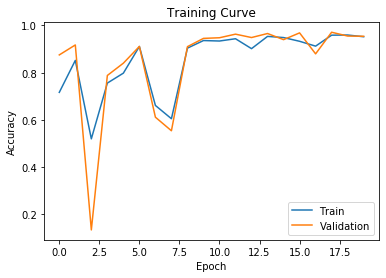

In [ ]:
# secondly I chose 200 as num of hidden units
model = RNN(input_size, 200, 2)   
train_rnn_network(model, train, valid, 64, 20, 5e-4)

In [ ]:
class RNN_new(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        self.name = "RNN_new"
        super(RNN_new, self).__init__()
        self.emb = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb[x]
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(torch.max(out, dim=1)[0])
        return out

Epoch 1; Loss 0.343279; Train Acc 0.934505; Val Acc 0.969507
Epoch 2; Loss 0.087249; Train Acc 0.943625; Val Acc 0.970404
Epoch 3; Loss 0.075201; Train Acc 0.958050; Val Acc 0.969507
Epoch 4; Loss 0.171268; Train Acc 0.956558; Val Acc 0.972197
Epoch 5; Loss 0.078077; Train Acc 0.970486; Val Acc 0.969507
Epoch 6; Loss 0.061556; Train Acc 0.978279; Val Acc 0.968610
Epoch 7; Loss 0.041418; Train Acc 0.979605; Val Acc 0.965919
Epoch 8; Loss 0.102804; Train Acc 0.977616; Val Acc 0.975785
Epoch 9; Loss 0.248150; Train Acc 0.989057; Val Acc 0.973991
Epoch 10; Loss 0.021029; Train Acc 0.984248; Val Acc 0.979372


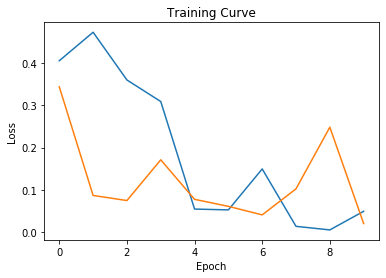

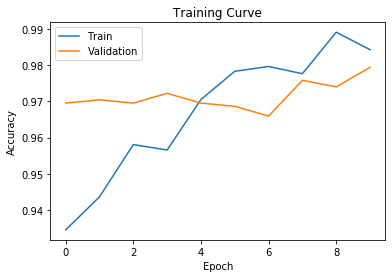

In [ ]:
# thirdly, I used a new RNN model with out = self.fc(torch.max(out, dim=1)[0]), which is a max pooling layer.
# the smaller num of iteration, a smaller batch_size and the same lr can achieve a better result
model = RNN_new(input_size, 100, 2)
train_rnn_network(model, train, valid, 32, 10, 5e-4)

Epoch 1; Loss 1.546614; Train Acc 0.548665; Val Acc 0.171300
Epoch 2; Loss 0.244328; Train Acc 0.943293; Val Acc 0.935426
Epoch 3; Loss 0.081553; Train Acc 0.955231; Val Acc 0.969507
Epoch 4; Loss 0.067803; Train Acc 0.960869; Val Acc 0.973094
Epoch 5; Loss 0.085156; Train Acc 0.963190; Val Acc 0.973094
Epoch 6; Loss 0.058907; Train Acc 0.967833; Val Acc 0.965919


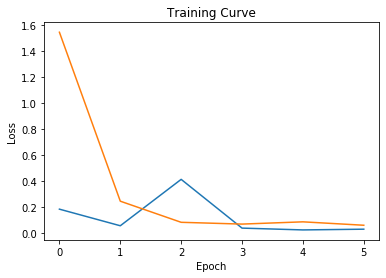

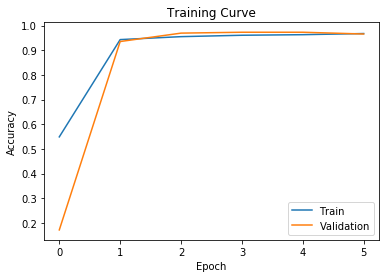

In [ ]:
# fourthly, I decrease the number of iterations and increase the learning rate to accelerate
model = RNN_new(input_size, 100, 2)   
train_rnn_network(model, train, valid, 64, 6, 1e-3)

Epoch 1; Loss 0.362756; Train Acc 0.940474; Val Acc 0.968610
Epoch 2; Loss 0.121151; Train Acc 0.954071; Val Acc 0.976682
Epoch 3; Loss 0.429468; Train Acc 0.954402; Val Acc 0.948879
Epoch 4; Loss 0.210038; Train Acc 0.962693; Val Acc 0.951570
Epoch 5; Loss 0.126962; Train Acc 0.977450; Val Acc 0.973094
Epoch 6; Loss 0.088498; Train Acc 0.965677; Val Acc 0.975785
Epoch 7; Loss 0.105513; Train Acc 0.980600; Val Acc 0.974888
Epoch 8; Loss 0.023568; Train Acc 0.978113; Val Acc 0.978475
Epoch 9; Loss 0.178455; Train Acc 0.979771; Val Acc 0.960538
Epoch 10; Loss 0.127782; Train Acc 0.985740; Val Acc 0.980269
Epoch 11; Loss 0.007172; Train Acc 0.991544; Val Acc 0.982960
Epoch 12; Loss 0.028426; Train Acc 0.994031; Val Acc 0.981166


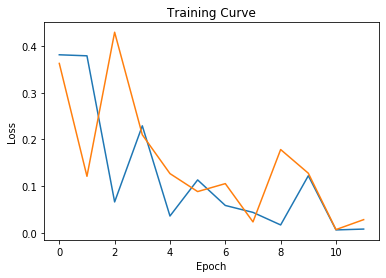

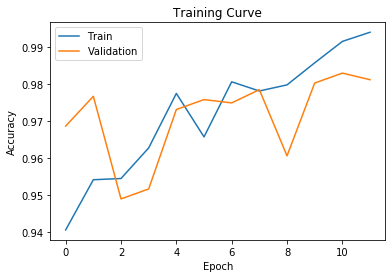

In [ ]:
# fifthly, I increased the number of hidden units and added more epoches
# this is the best model I got during the tuning hyperparameters
model = RNN_new(input_size, 200, 2)
train_rnn_network(model, train, valid, 64, 12, 1e-3)

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)
best_model = RNN_new(input_size, 200, 2)
best_model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format("RNN_new", 64, 1e-3, 11)
state = torch.load(best_model_path)
best_model.load_state_dict(state)

false_positive_rate = 1 - get_accuracy(best_model, valid_nospam, 32)
false_negative_rate = 1 - get_accuracy(best_model, valid_spam, 32)

print("false positive rate is:", false_positive_rate)
print("false negative rate is:", false_negative_rate)

false positive rate is: 0.010362694300518172
false negative rate is: 0.07999999999999996


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

In [ ]:
# false positive means a message is a spam but is classifies as a non-spam. The
# impact would be just have overwhelming and annoying messages in my phone.
# false negative means a message is a non-spam but is classified as a spam. The
# impact would be larger, because I would probably miss some important messages, 
# such as an offer.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [ ]:
best_model = RNN_new(input_size, 200, 2)
best_model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format("RNN_new", 64, 1e-3, 11)
state = torch.load(best_model_path)
best_model.load_state_dict(state)

test_accuracy = get_accuracy(best_model, test, 32)
print("test accuracy is:", test_accuracy)

test accuracy is: 0.9901256732495511


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
# Create a Dataset of only spam test examples
test_spam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)
# Create a Dataset of only non-spam test examples
test_nospam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)

best_model = RNN_new(input_size, 200, 2)
best_model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format("RNN_new", 64, 1e-3, 11)
state = torch.load(best_model_path)
best_model.load_state_dict(state)

false_positive_rate = 1 - get_accuracy(model, test_nospam, 32)
false_negative_rate = 1 - get_accuracy(model, test_spam, 32)

print("false positive rate for test dataset is:", false_positive_rate)
print("false negative rate for test dataset is:", false_negative_rate)

false positive rate for test dataset is: 0.030051813471502542
false negative rate for test dataset is: 0.0738255033557047


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [ ]:
best_model = RNN_new(input_size, 200, 2)
best_model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format("RNN_new", 64, 1e-3, 11)
state = torch.load(best_model_path)
best_model.load_state_dict(state)

msg = "machine learning is sooo cool!"
print(text_field.vocab.stoi)
msg_list = []
for index in range(0, len(msg)):
    msg_list.append(text_field.vocab.stoi[msg[index]])
print(msg_list)
tset_message = torch.LongTensor([msg_list])
pred = best_model(tset_message)
a = pred[0][1]
prob_of_spam = np.exp(float(pred[0][1])) / (np.exp(float(pred[0][0])) + np.exp(float(pred[0][1])))
print("probability of the message to be spam is:", prob_of_spam)

defaultdict(<function _default_unk_index at 0x7fca6f85e9d8>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, 'h': 13, '0': 14, 'd': 15, '.': 16, 'c': 17, 'm': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, 'f': 23, '1': 24, 'b': 25, '2': 26, 'T': 27, '8': 28, 'k': 29, 'E': 30, 'v': 31, '5': 32, 'S': 33, 'C': 34, 'O': 35, 'I': 36, '4': 37, 'N': 38, 'x': 39, '7': 40, '3': 41, 'A': 42, '6': 43, '!': 44, ',': 45, 'R': 46, '9': 47, 'P': 48, 'M': 49, 'U': 50, 'W': 51, 'L': 52, 'H': 53, 'D': 54, 'B': 55, 'F': 56, 'Y': 57, 'G': 58, '/': 59, "'": 60, '?': 61, '£': 62, '-': 63, '&': 64, ':': 65, 'X': 66, 'V': 67, 'z': 68, 'j': 69, '*': 70, 'K': 71, ')': 72, 'J': 73, ';': 74, '+': 75, 'q': 76, '(': 77, 'Q': 78, '"': 79, '#': 80, '@': 81, '=': 82, '>': 83, 'Z': 84, 'ü': 85, '$': 86, 'Ü': 87, '|': 88, '_': 89, '\x92': 90, '<': 91, '%': 92, '‘': 93, '[': 94, ']': 95, '\x93': 96, '’': 97, '…': 98, 'ú': 99, '–': 100, '~': 101, '\t': 102, '\n

### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

In [ ]:
# It is not an easy task.
# we can make a Bayesian classifier.
# firstly, we should get the count of occurances of all the words in spam 
# message set and ham message set respectively. Then, calculate the occurance
# prob of each word in both sets. Let pd be occurance of word d in spam and 
# wd be occurance of word in ham. Using Laplace smoothing
# pd = (# occurance in spam bag + 1) / (# of total words in spam bag) + (# of total vocabulary)
# wd = (# occurance in ham bag + 1) / (# of total words in ham bag) + (# of total vocabulary)
# then we can compare P1 and P2
# where P1 = PI(pd**(# of occurance of word d in test message)) * (prior prob of a spam occurs) (Note: PI is the accumulated multiplication over all words in vocabulary)
# P2 = PI(wd**(# of occurance of word d in test message)) * (prior prob of a ham occurs)
# if P1>P2, decision is spam, else, decision is ham.